In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm

### The Big Problem

In *A - Species inference from movement acoustics*, I discussed using hydrophones to classify deep-sea creatures from the acoustic signatures of their movements. Here, I want to pivot slightly to a closely related problem: how to find animal hotspots in the first place. Say we want to measure biodiversity. In order to generate good statistics we need lots of data, which means going to high species density places. Our goal is to identify regions rich in observable wildlife. 

The difficulty is that collecting observations is slow and expensive. At the moment optimizing species density requires deploying equipment, descending to depth, capturing sufficient video, returning to the surface, analyzing it, and then possibly relocating to a new site.

Each data point is costly, so we need methods that make sampling as efficient as possible. Fortunately, machine learning offers tools designed specifically for sample-efficient exploration.

### The Solution: Gaussian Processes

Gaussian Processes (GPs) are particularly well suited to this task because they provide not only predictions, but also uncertainty estimates at unobserved locations. This allows us to compute the *expected improvement* of sampling at a new site and choose the location that maximizes this quantity.

#### A brief overview

Say that you want to generate some realistic time-series functions. What might work? Ideally you want something which encodes the basic propery of any curve, that points close to eachother are highly correlated. Well, one option is to imagine each of the values as being a dimension in a multivariate normal distribution. Then you could specify that values next to eachother have a high degree of correlation with one another. For example, imagine if two points when they are next to eachother correlate 1, and if they are further apart they correlate 0. You can specify this using some function of the distance. Then you end up with a covariance matrix which would look something like this:

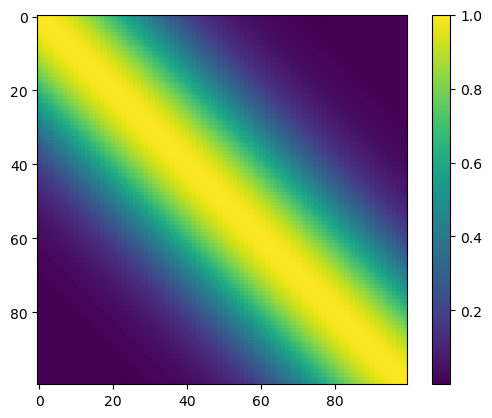

In [2]:
n = 100

x = np.arange(n)

cov = np.exp(-0.001 * (x.reshape(-1, 1) - x.reshape(1, -1))**2)
cov += 1e-8 * np.eye(len(x))

plt.imshow(cov)
plt.colorbar()
plt.show()

The point at 20 is highly correlated with other stuff around 20, but not correlated at all with things at 40 onwards. 

And if we choose to sample from this covariance using a mean of 0...

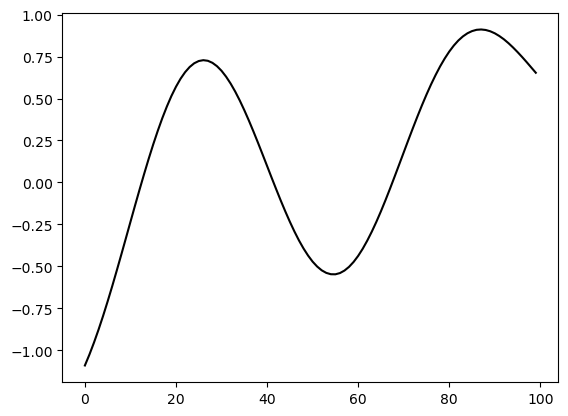

In [3]:
samples = np.random.multivariate_normal(np.zeros(n), cov)
plt.plot(samples, color="black")
plt.show()

Hey! We get a realistic-looking curve! And in fact we can generate an infinite number of realistic-looking curves. The covariance structure imposes a limit on what curves we can make. See below where we generate a bunch of different curves. 

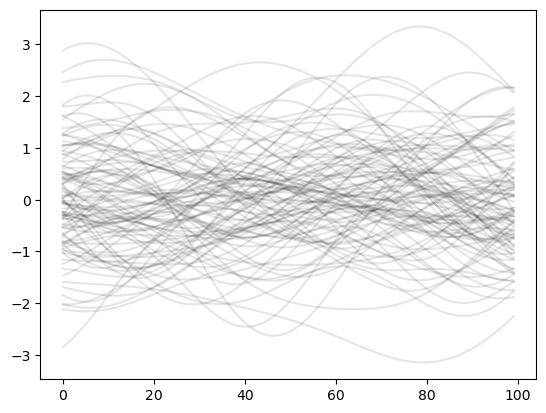

In [4]:
for i in range(100):
    samples = np.random.multivariate_normal(np.zeros(n),cov)
    plt.plot(samples,color="black",alpha=0.1)
plt.show()

Okay so we have a generative model for realistic curves. But how do we account for actual data? Well, one option is to generate curves and reject the ones which don't go through your data. For instance, if I know my curve goes through (40,0) and (60,1), then I can just filter and grab only those which basically do that:

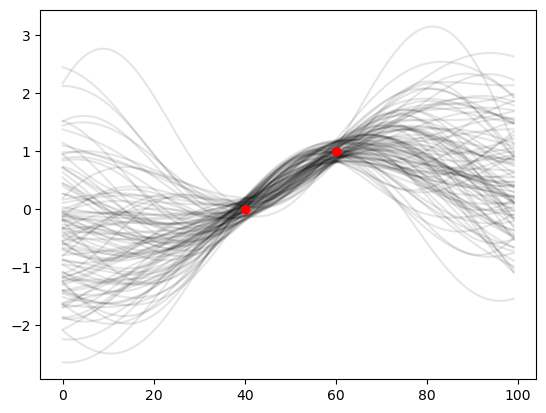

In [5]:
i = 0
while i<100:
    samples = np.random.multivariate_normal(np.zeros(n),cov)
    if np.isclose(samples[40],0,atol=0.2) and np.isclose(samples[60],1,atol=0.2):
        plt.plot(samples,color="black",alpha=0.1, zorder=1)
        i+=1
plt.scatter([40,60],[0,1],color="red", zorder=10)
plt.show()

This works, but the brilliant thing about gaussian processes is we can do this conditioning analytically. All we need to do is use gaussian conditioning on the points which we know!

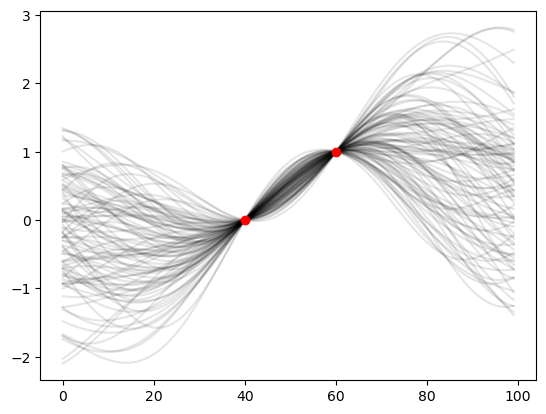

In [6]:
def condition_gaussian(mean, cov, known_indicies, known_values):
    mean = np.asarray(mean)
    cov = np.asarray(cov)

    known_indicies = np.asarray(known_indicies)
    known_values = np.asarray(known_values)

    all_indicies = np.arange(len(mean))
    unknown_indicies = np.setdiff1d(all_indicies, known_indicies)

    mu_k = mean[known_indicies]
    mu_u = mean[unknown_indicies]

    Sigma_kk = cov[np.ix_(known_indicies, known_indicies)]
    Sigma_ku = cov[np.ix_(known_indicies, unknown_indicies)]
    Sigma_uk = cov[np.ix_(unknown_indicies, known_indicies)]
    Sigma_uu = cov[np.ix_(unknown_indicies, unknown_indicies)]

    Sigma_kk_inv = np.linalg.inv(Sigma_kk)

    cond_mean = mu_u + Sigma_uk @ Sigma_kk_inv @ (known_values - mu_k)
    cond_cov = Sigma_uu - Sigma_uk @ Sigma_kk_inv @ Sigma_ku

    return cond_mean, cond_cov

known_indices = np.array([40, 60])
known_values  = np.array([0.0, 1.0])

new_mean, new_cov = condition_gaussian(np.zeros(n), cov, known_indices, known_values)

all_indices = np.arange(n)
unknown_indices = np.setdiff1d(all_indices, known_indices)

i = 0
while i < 100:
    sample_u = np.random.multivariate_normal(new_mean, new_cov)
    full_sample = np.zeros(n)
    full_sample[unknown_indices] = sample_u
    full_sample[known_indices] = known_values
    plt.plot(full_sample, color="black", alpha=0.1, zorder=1)
    i += 1

plt.scatter(known_indices, known_values, color="red", zorder=10)
plt.show()

Fantastic!

To see this another way consider the simplest possible case: two locations, one observed (training) point and one unobserved (test) point.

Suppose we define the covariance between any two points as

$$
k(d) = \exp(-12 d^2)
$$

where $d$ is the distance between them. This function looks something like this:

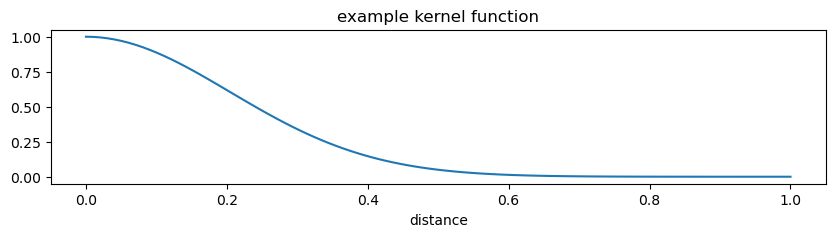

In [7]:
distances = np.linspace(0,1,100)
kernel = np.exp(-12*distances**2)
plt.figure(figsize=(10,2))
plt.plot(distances, kernel)
plt.title("example kernel function")
plt.xlabel("distance")
plt.show()

If the distance between the training point and the test point is $d = 0.2$, this kernel yields a covariance of approximately $0.618$.

If we go back to our 2 points case the joint covariance matrix for the two function values is then

$$
\begin{pmatrix}
1 & 0.618 \\
0.618 & 1
\end{pmatrix}
$$

Once we have this covariance we can conditioning on the observed value at the training point to infer both the expected value and the uncertainty at the test point. See the below.

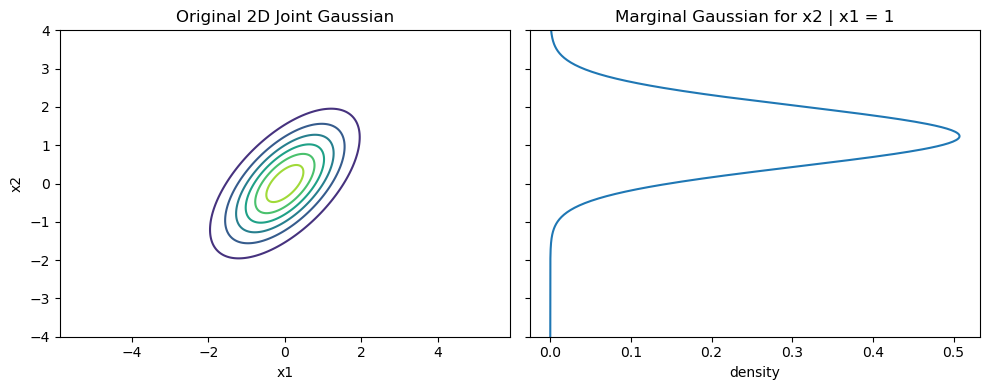

In [8]:
mean = np.array([0.0, 0.0])
cov = np.array([
    [1.0, 0.618],
    [0.618, 1.0]
])

# This says we believe there is a 0.3 correlation between the two
# Imagine we then see that the first value is 2. 
# Then we condition with that value to get a new gaussian over the values for the second.

# Plotting

fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(10, 4),
    sharey=True
)

# ----- LEFT: Original 2D Joint Gaussian -----

rv = multivariate_normal(mean=mean, cov=cov)

x = np.linspace(-4, 4, 200)
y = np.linspace(-4, 4, 200)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

Z = rv.pdf(pos)

axes[0].contour(X, Y, Z)
axes[0].set_xlabel("x1")
axes[0].set_ylabel("x2")
axes[0].set_title("Original 2D Joint Gaussian")
axes[0].axis("equal")

# ----- RIGHT: Marginal on the second variable -----

cond_mean, cond_cov = condition_gaussian(
    mean,
    cov,
    known_indicies=[0],
    known_values=[2.0]
)

rv_cond = norm(loc=cond_mean[0], scale=np.sqrt(cond_cov[0, 0]))

x2 = np.linspace(-4, 4, 400)
pdf_x2 = rv_cond.pdf(x2)

axes[1].plot(pdf_x2, x2)
axes[1].set_xlabel("density")
axes[1].set_title("Marginal Gaussian for x2 | x1 = 1")

plt.tight_layout()
plt.show()

Here on the left we see the prior over the value at both points. This was generated by using the distance between the points to get the covariance. Then on the right we see what the distribution over the value of the second point looks like after conditioning on the true value of the first. 

Importantly both points could be images, they could be coordinates, they could be anything. All we do is specify that their outputs are jointly distributed in a multivariate gaussian.

### Application to the scarce-data problem

Because this method generates realistic error bars on it's predictions we can determine the expected improvement of sampling at a new location. We don't just want to know how good some point is expected to be, we want to weigh this by the odds we improve at all. This requires knowing the range of options.

Expected improvement is how much better we expect our highest sample to be, after trying the new sample. If we maximise this quantity we are doing smart inference about where to sample next. This becomes essential if we have a fixed number of samples we can take. 

Let's go back to our ocean setting an imagine we have some distribution over observation frequency on the sea floor (1 dimensional for now):

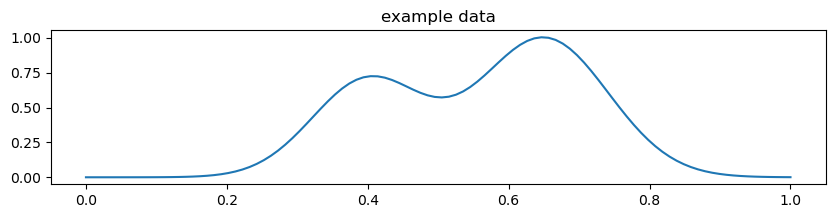

In [9]:
def test_function(x):
    return 0.7 * np.exp(-80*(x-0.4)**2) + np.exp(-60*(x-0.65)**2)

x = np.linspace(0,1,100)
y = test_function(x)
plt.figure(figsize=(10,2))
plt.plot(x,y)
plt.title("example data")
plt.show()

Here the y axis refers to the number of fish / creatures swimming at each point. 

Now let's try out the gaussian process idea. Here we'll take 1 sample at a time, update our beliefs about the values of the other points (using the covariance as determined by distance), and then sample next at the point where there is the greatest expected improvement.

Step 0: sampling at 0.00


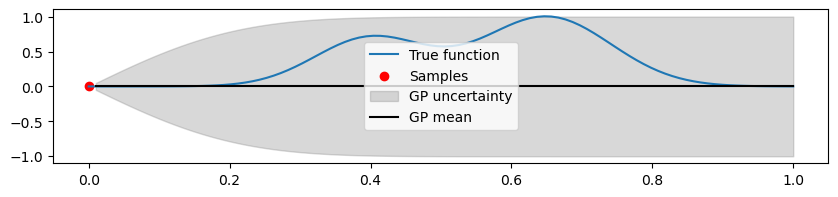

Step 1: sampling at 1.00


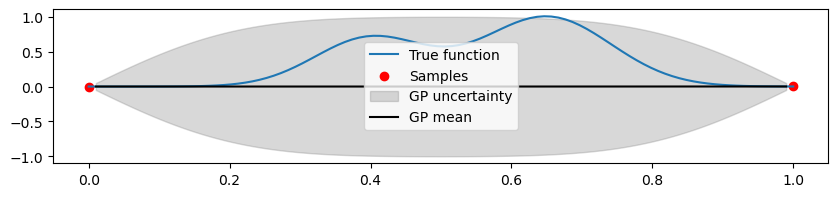

Step 2: sampling at 0.51


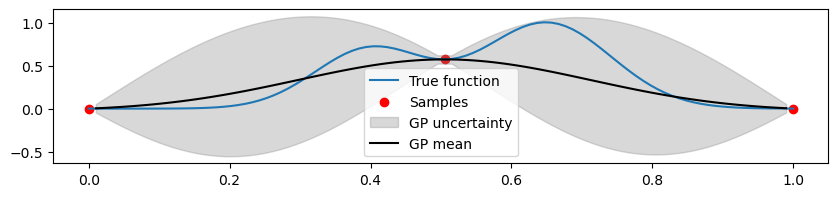

Step 3: sampling at 0.31


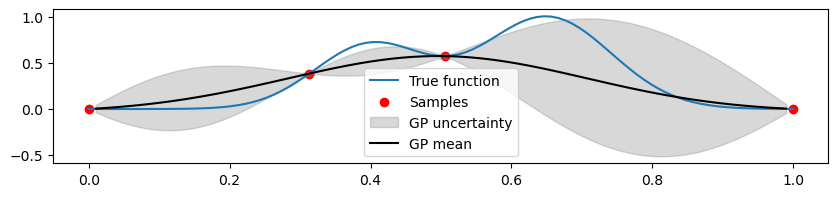

Step 4: sampling at 0.71


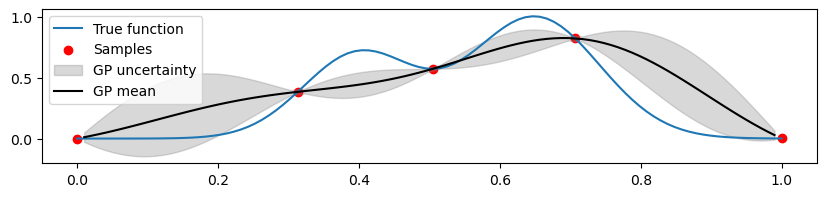

Step 5: sampling at 0.65


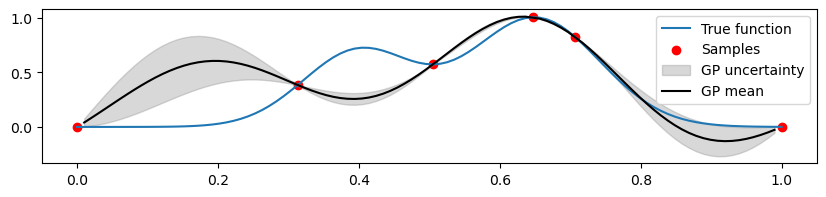

Step 6: sampling at 0.64


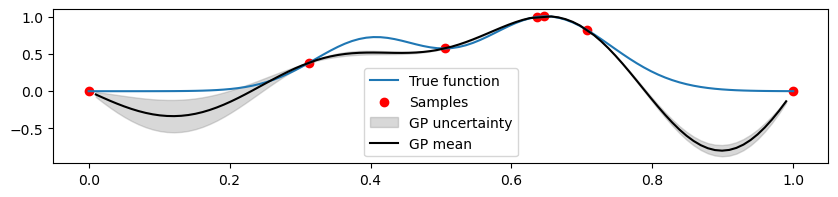

Step 7: sampling at 0.12


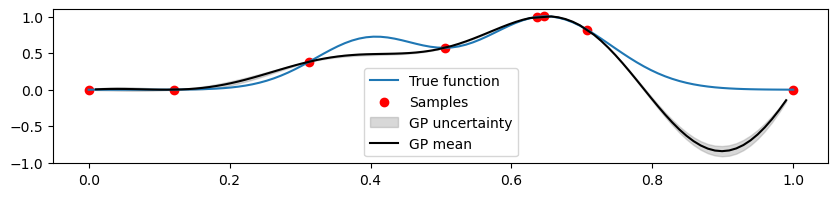

In [10]:
def expected_improvement(mean, std, best):
    Z = (mean - best) / std
    return (mean - best) * norm.cdf(Z) + std * norm.pdf(Z)

def run_GP_optimization_1d(f, x, max_steps):
    y = f(x)

    # Initial GP prior
    mean = np.zeros(len(x))
    cov = np.exp(-12 * (x.reshape(-1, 1) - x.reshape(1, -1))**2)
    cov += 1e-8 * np.eye(len(x))
    std = np.sqrt(np.diag(cov))

    current_peak = 0.0

    x_copy = x.copy()
    y_copy = y.copy()

    x_samples = []
    y_samples = []

    for step in range(max_steps):
        expected_improvements = expected_improvement(mean, std, current_peak)
        
        # Select next point
        where_to_sample = np.argmax(expected_improvements)
        print(f"Step {step}: sampling at {x_copy[where_to_sample]:.2f}")

        # Observe value and condition GP
        observed_y = y_copy[where_to_sample]
        mean, cov = condition_gaussian(
            mean, cov, [where_to_sample], observed_y
        )
        std = np.sqrt(np.diag(cov))

        current_peak = max(current_peak, observed_y)

        # Record sample
        x_samples.append(x_copy[where_to_sample])
        y_samples.append(observed_y)

        # Remove sampled point from candidate set
        x_copy = np.delete(x_copy, where_to_sample)
        y_copy = np.delete(y_copy, where_to_sample)

        # Plot
        plt.figure(figsize=(10, 2))
        plt.plot(x, y, label="True function")
        plt.scatter(x_samples, y_samples, color="red", label="Samples")
        plt.fill_between(
            x_copy, mean - std, mean + std,
            color="gray", alpha=0.3, label="GP uncertainty"
        )
        plt.plot(x_copy, mean, color="black", label="GP mean")
        plt.legend()
        plt.show()

run_GP_optimization_1d(test_function, np.linspace(0,1,100), 8)

There we go! Notice that when the algorithm starts to know a particular spot it will automatically go to wherever it hasn't covered yet. This is different behaviour to something like gradient descent, which will just take local steps upwards. It finds fairly quickly the maximum point and uses few samples to do it. While this method will struggle to train a neural network, due to the high dimensionality and issues with conditioning the gaussian, as well as the curse of dimensionality, navigating a 2d or 3d function is perfectly doable.

2d example:

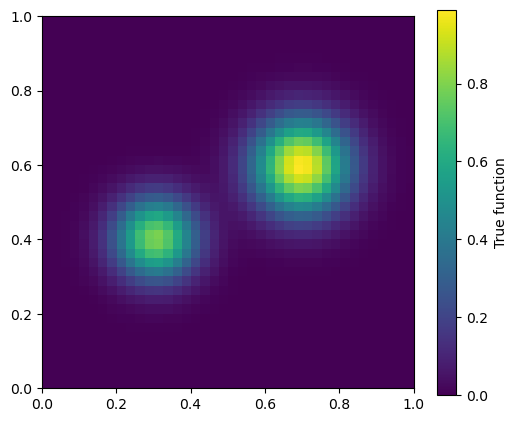

In [11]:
def test_function_2d(X):
    return 0.8 * np.exp(-80*((X[:,0]-0.3)**2 + (X[:,1]-0.4)**2)) + 1.0 * np.exp(-60*((X[:,0]-0.7)**2 + (X[:,1]-0.6)**2))

n = 40
x1 = np.linspace(0, 1, n)
x2 = np.linspace(0, 1, n)
X1, X2 = np.meshgrid(x1, x2)
X = np.column_stack([X1.ravel(), X2.ravel()])
Y = test_function_2d(X).reshape(n, n)

plt.figure(figsize=(6,5))
plt.imshow(Y, extent=(0,1,0,1), origin="lower", cmap="viridis")
plt.colorbar(label="True function")
plt.show()

Step 0: sampling at [0. 0.]
Step 1: sampling at [0.8974359  0.82051282]
Step 2: sampling at [0.28205128 0.97435897]
Step 3: sampling at [0.74358974 0.20512821]
Step 4: sampling at [0.         0.53846154]
Step 5: sampling at [0.48717949 0.56410256]
Step 6: sampling at [0.41025641 0.        ]
Step 7: sampling at [1.         0.46153846]
Step 8: sampling at [1. 0.]
Step 9: sampling at [0.61538462 1.        ]
Step 10: sampling at [0.25641026 0.30769231]
Step 11: sampling at [0. 1.]
Step 12: sampling at [0.         0.25641026]
Step 13: sampling at [0.46153846 0.28205128]
Step 14: sampling at [0.25641026 0.58974359]
Step 15: sampling at [1. 1.]
Step 16: sampling at [0.74358974 0.53846154]
Step 17: sampling at [0.69230769 0.69230769]
Step 18: sampling at [0.79487179 0.61538462]
Step 19: sampling at [0.20512821 0.1025641 ]


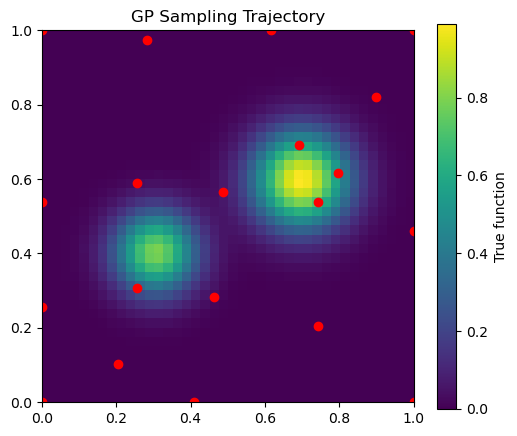

In [12]:
def rbf_kernel(Xa, Xb, lengthscale=0.2):
    sqdist = (
        np.sum(Xa**2, axis=1)[:, None]
        + np.sum(Xb**2, axis=1)[None, :]
        - 2 * Xa @ Xb.T
    )
    return np.exp(-sqdist / (2 * lengthscale**2))

def run_GP_optimization_2d(f, X, max_steps, kernel):
    y = f(X)

    mean = np.zeros(len(X))
    cov  = kernel(X, X) + 1e-8 * np.eye(len(X))
    std  = np.sqrt(np.diag(cov))

    best = -np.inf

    X_copy = X.copy()
    y_copy = y.copy()

    X_samples = []
    y_samples = []

    for step in range(max_steps):
        EI = expected_improvement(mean, std, best)
        where = np.argmax(EI)

        x_obs = X_copy[where]
        y_obs = y_copy[where]

        print(f"Step {step}: sampling at {x_obs}")

        mean, cov = condition_gaussian(mean, cov, [where], y_obs)
        std = np.sqrt(np.diag(cov))

        best = max(best, y_obs)

        X_samples.append(x_obs)
        y_samples.append(y_obs)

        X_copy = np.delete(X_copy, where, axis=0)
        y_copy = np.delete(y_copy, where)

    return np.array(X_samples), np.array(y_samples)

X_samples, y_samples = run_GP_optimization_2d(test_function_2d, X, max_steps=20, kernel=rbf_kernel)

plt.figure(figsize=(6,5))
plt.imshow(Y, extent=(0,1,0,1), origin="lower", cmap="viridis")
plt.colorbar(label="True function")

xs = np.array(X_samples)
plt.scatter(xs[:,0], xs[:,1], color="red")

plt.title("GP Sampling Trajectory")
plt.show()


So the model here manages to place 3 samples near the peak point after just 20 steps.

### But what about travel distance?

Notice that in the above cases the next sample is taken regardless of how far away it might be from the one before. But what if the cost of these samples grows with distance? Imagine an autonomous vehicle that needs to travel to wherever the next sample is. What do we do then? Fortunately the gaussian process method can be improved to also account for this, but it's not trivial. When we want to minimize the number of samples we use a greedy approach and just choose the best point for the next sample. This isn't always going to work, but it's a good idea. Now when we impose some broader energy cost things get harder. With a fixed energy budget, a cost of moving, and a cost of sampling, you need to balance taking the best sample now with taking more samples overall. Non trivial, a good paper to read might be https://arxiv.org/pdf/1401.3462. That also looks at the multiagent scenario. This is an interesting area of machine learning. 